In [1]:
import librosa
import numpy as np
import numba
import scipy.signal as signal
import matplotlib.pyplot as plt
from IPython.display import Audio
%matplotlib nbagg

### For a frame of audio, I can plot it's ACF over lags

In [2]:
def eng_to_voicing_prob(A0, quantile=75, epsilon=5e-7, Q=None):
    if Q is None:
        Q = np.percentile(A0, quantile)
    else: 
        quantile = None
    print(quantile, Q)
    V = np.minimum(A0, Q) / (Q + epsilon)
    return V

def constrained_acf(y, sr, open_str_midi):
    midi_min = open_str_midi - 2
    midi_max = open_str_midi + 24
    fmin = librosa.midi_to_hz(midi_min)
    fmax = librosa.midi_to_hz(midi_max)

    max_lag = librosa.time_to_samples(1./fmin, sr=sr)[0]
    min_lag = librosa.time_to_samples(1./fmax, sr=sr)[0]

    print('max_lag:{} min_lag:{}'.format(max_lag, min_lag))
    yf = librosa.util.frame(y, frame_length=max_lag)
    acf = librosa.autocorrelate(yf, axis=0)
    print('acf.shape:{}'.format(acf.shape))
    
    return acf, min_lag

def lag_to_fret(cliped_acf_frame, min_lag, sr, open_str_midi):
    real_lag = range(len(cliped_acf_frame))[:] + min_lag
    freq = 1. / librosa.samples_to_time(real_lag, sr=sr)
    pitch = librosa.hz_to_midi(freq)
    fret = pitch - open_str_midi
    new_x_cord = np.arange(-2,24,0.25)
    frame_fret_energy = np.interp(new_x_cord, fret[::-1], cliped_acf_frame[::-1])
    return fret, frame_fret_energy

def compute_fret_energy(cliped_acf, min_lag, sr, open_str_midi):
    fret_energy = []
    for frame in cliped_acf.T:
        fret, frame_fret_energy = lag_to_fret(frame, min_lag, sr, open_str_midi)
        fret_energy.append(frame_fret_energy)
    
    return fret, np.array(fret_energy).T

In [3]:
str_midi_dict = {
    0: 40,
    1: 45,
    2: 50,
    3: 55,
    4: 59,
    5: 64
}

acf0 = []
fret_energys = []
acf0_size = None
for string_number in range(6):
#     mono_path = '/Users/tom/Music/DataSet/test-set_processed/jf_Funk3-112-C#_s_hex_cln/{}.wav'.format(string_number)
    mono_path = '/Users/tom/Music/DataSet/test-set_processed/vl_Jazz2-110-Bb_s_hex_cln/{}.wav'.format(string_number)

    y, sr = librosa.load(mono_path)
    print(len(y))
    acf, min_lag = constrained_acf(y, sr, str_midi_dict[string_number])
    if acf0_size == None:
        acf0_size = acf.shape[1]
    cliped_acf = np.clip(acf[min_lag:], 0, None) / acf[0]
    fret, fret_energy = compute_fret_energy(cliped_acf, min_lag, sr, str_midi_dict[string_number])
    acf0.append(acf[0, :acf0_size])
    fret_energys.append(fret_energy[:, :acf0_size])

acf0 = np.asarray(acf0)
fret_energys = np.asarray(fret_energys)

749700
max_lag:300 min_lag:66
acf.shape:(300, 1464)
749700
max_lag:225 min_lag:50
acf.shape:(225, 1464)
749700
max_lag:168 min_lag:37
acf.shape:(168, 1464)
749700
max_lag:126 min_lag:28
acf.shape:(126, 1465)
749700
max_lag:100 min_lag:22
acf.shape:(100, 1465)
749700
max_lag:75 min_lag:16
acf.shape:(75, 1465)


### Two ways to viterbi


In [4]:
@numba.jit(nopython=True)
def _viterbi(logp, logA, V, ptr, S):
    T, m = logp.shape
    
    V[0] = logp[0]
    
    for t in range(1, T):
        # Want V[t, j] <- p[t, j] * max_k V[t-1, k] * A[k, j]
        #    assume at time t-1 we were in state k
        #    transition k -> j

        # Broadcast over rows:
        #    Tout[k, j] = V[t-1, k] * A[k, j]
        #    then take the max over columns
        # 
        # We'll do this in log-space for stability

        Tout = V[t-1] + logA.T

        # Unroll the max/argmax loop to enable numba support
        for j in range(m):
            ptr[t, j] = np.argmax(Tout[j])
            V[t, j] = logp[t, j] + np.max(Tout[j])
            
    # Now roll backward
    
    # Get the last state
    S[-1] = np.argmax(V[-1])
    
    for t in range(T-2, -1, -1):
        S[t] = ptr[t+1, S[t+1]]
        
    return S, V, ptr


def viterbi(p, A):
    '''Viterbi decoding for discriminative HMMs
    
    Parameters
    ----------
    p : np.ndarray [shape=(T, m)], non-negative
        p[t] is the distribution over states at time t.
        Each row must sum to 1.
        
    A : np.ndarray [shape=(m, m)], non-negative
        A[i,j] is the probability of a transition from i->j.
        Each row must sum to 1.
        
    Returns
    -------
    s : np.ndarray [shape=(T,)]
        The most likely state sequence
    '''
    
    T, m = p.shape
    
    assert A.shape == (m, m)
    
    assert np.all(A >= 0)
    assert np.all(p >= 0)
    assert np.allclose(A.sum(axis=1), 1)
    assert np.allclose(p.sum(axis=1), 1)
    
    V = np.zeros((T, m), dtype=float)
    
    ptr = np.zeros((T, m), dtype=int)
    
    logA = np.log(A + 1e-10)
    logp = np.log(p + 1e-10)
    S = np.zeros(T, dtype=int)
    
    return _viterbi(logp, logA, V, ptr, S)

def make_self_transition(N, alpha=0.05):
    
    T = np.empty((N, N), dtype=float)
    T[:] = alpha / (N - 1)
    
    np.fill_diagonal(T, 1-alpha)
    
    return T


def make_bump_transition(N, window='hann', width=5, alpha=0.05):
    
    T = np.eye(N, dtype=float)
    w = librosa.filters.get_window(window, width, fftbins=False)[np.newaxis]
    T = signal.convolve(T, w, mode='same',)
    
    T = (1 - alpha) * T + alpha
    return T / T.sum(axis=1, keepdims=True)


def mod_bump_transition(N, window='hann', width=5, alpha=0.05):
    
    T = np.eye(N, dtype=float)
    w = librosa.filters.get_window(window, width, fftbins=False)[np.newaxis]
    T = signal.convolve(T, w, mode='same',)
    
    T = (1 - alpha) * T + alpha
    # treat last row differently
    T = T / T.sum(axis=1, keepdims=True)
    
    
    T[-1, :-1] = (1 - T[-1, -1]) / (N - 1)
    T[:-1, -1] = (1 - T[-1, -1]) / (N - 1)
    return T / T.sum(axis=1, keepdims=True)


def mod_string_bump_transition(N, window='hann', width=5, alpha=0.005):
    T_i = np.eye(N, dtype=float)
    w = librosa.filters.get_window(window, width, fftbins=False)[np.newaxis]
    T_i = signal.convolve(T_i, w, mode='same')
    # open string
    T_o = np.zeros((N, N), dtype=float)
    T_o[:, 8] = 1
    T_o = signal.convolve(T_o, w, mode='same')
    T_o = T_o + T_o.T
    # combine
    T = T_o + T_i
    # unifrom bed
    T = (1 - alpha) * T + alpha
    # treat last row differently
    T = T / T.sum(axis=1, keepdims=True)
    
    
    T[-1, :-1] = (1 - T[-1, -1]) / (N - 1)
    T[:-1, -1] = (1 - T[-1, -1]) / (N - 1)
    return T / T.sum(axis=1, keepdims=True)

def make_uniform_transition(N):
    T = np.ones((N,N))
    return T / T.sum(axis=1, keepdims=True)

In [5]:
def energy_to_prob(fret_energys, acf0s):
    unvoiced_probs = (1 - eng_to_voicing_prob(acf0, Q=0.005)) * np.max(fret_energy)
    Ps = []
    for fe, up in zip(fret_energys, unvoiced_probs):
        total_energy = np.vstack((fe, up))
#         total_energy = fe
        sigsq = np.mean(np.abs(total_energy))
        P = np.exp(0.5 * total_energy / sigsq)
        P = librosa.util.normalize(P.astype(np.float64), axis=0, norm=1)
        Ps.append(P)
    return np.asarray(Ps)

Ps = energy_to_prob(fret_energys, acf0)

(None, 0.005)


<IPython.core.display.Javascript object>


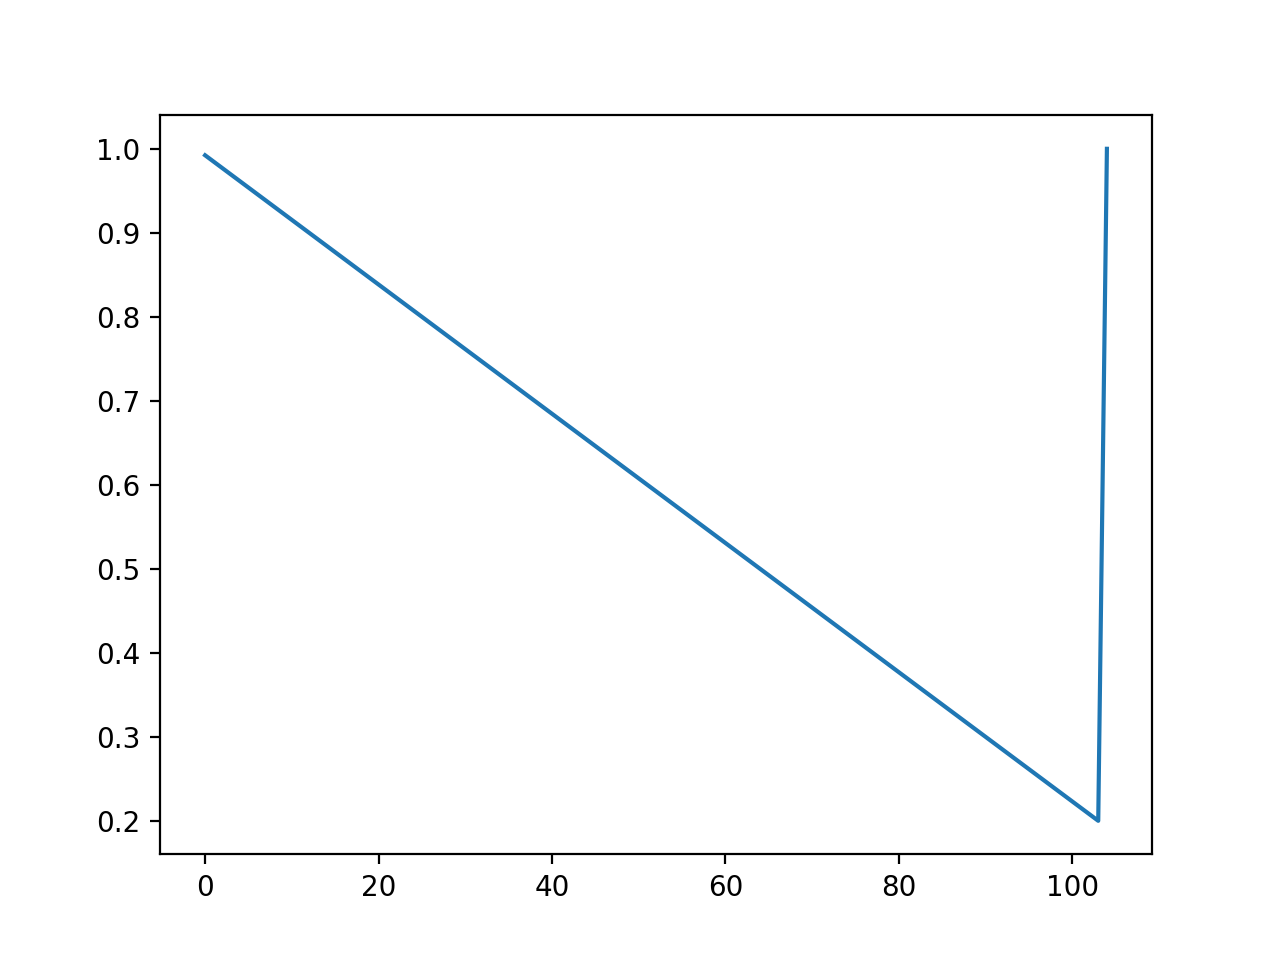

<IPython.core.display.Javascript object>


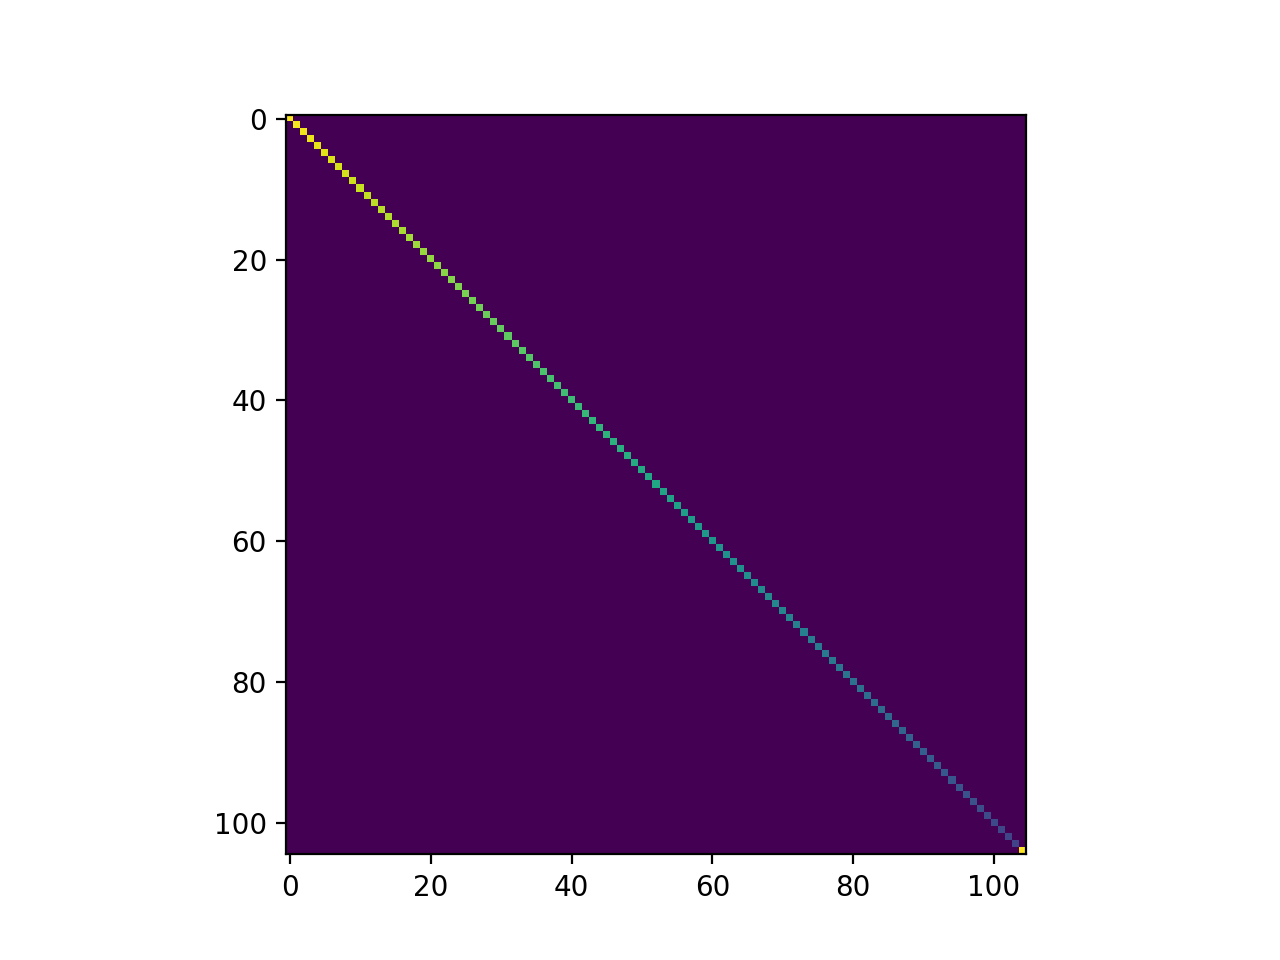

In [6]:
weight = (np.arange(Ps.shape[1]) + 25) / float(Ps.shape[1] + 25)
weight = weight[::-1]
weight[-1] = 1
weight_mat = np.diag(weight)
plt.figure()
plt.plot(weight)
plt.figure()
plt.imshow(weight_mat)

In [76]:
Ps.shape

(6, 105, 1464)

In [24]:
n_pitches = Ps.shape[1]
T = mod_bump_transition(n_pitches, width=10, alpha=5e-2)
# T = make_bump_transition(n_pitches, width=10, alpha=5e-2)

<IPython.core.display.Javascript object>


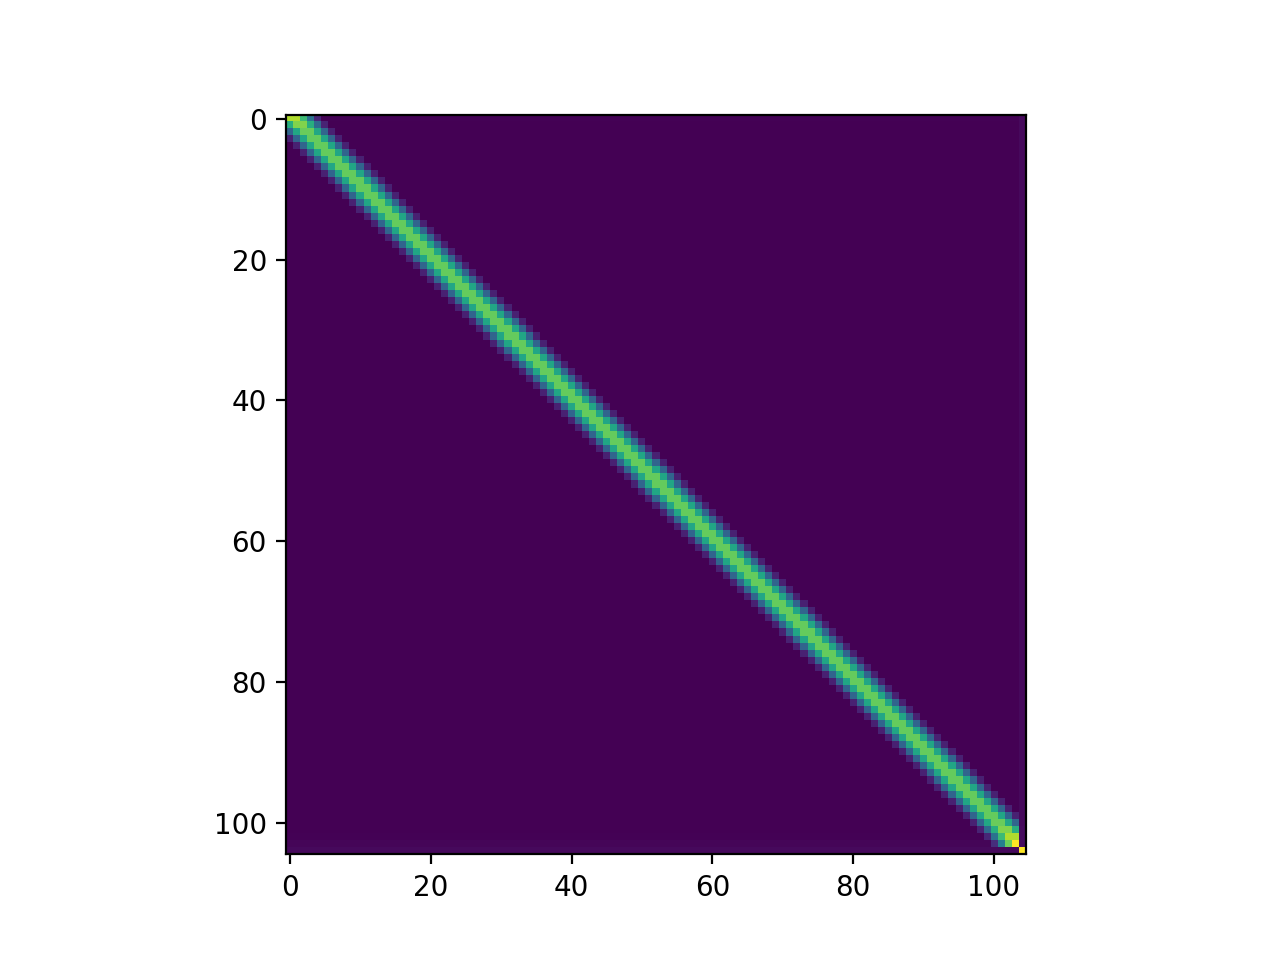

In [25]:
plt.figure()
plt.imshow(T)

In [26]:
STATE_INDEX = np.arange(-2,24,0.25)

def state_to_freq(states, open_str_midi):
    f_detect = []
    for s in states:
        if s > 0 :  # voiced
            fret = STATE_INDEX[s]
            midi = open_str_midi + fret
            freq = librosa.midi_to_hz(midi)[0]
            f_detect.append(freq)
        else:  # unvoiced
            f_detect.append(-1)

    return f_detect



In [27]:
state_detects = []

def joint_viterbi(Ps, weight_mat):
    for string_num in range(6):
        P = np.dot(weight_mat, Ps[string_num])
        P = librosa.util.normalize(P.astype(np.float64), axis=0, norm=1)
        seq, values, pointers = viterbi(P.T, T)
        state_detect = seq
        state_detect[seq == Ps.shape[1] - 1] *= -1 # Ps.shape[1] is n_pitches
        state_detects.append(state_detect)
    return state_detects

<IPython.core.display.Javascript object>


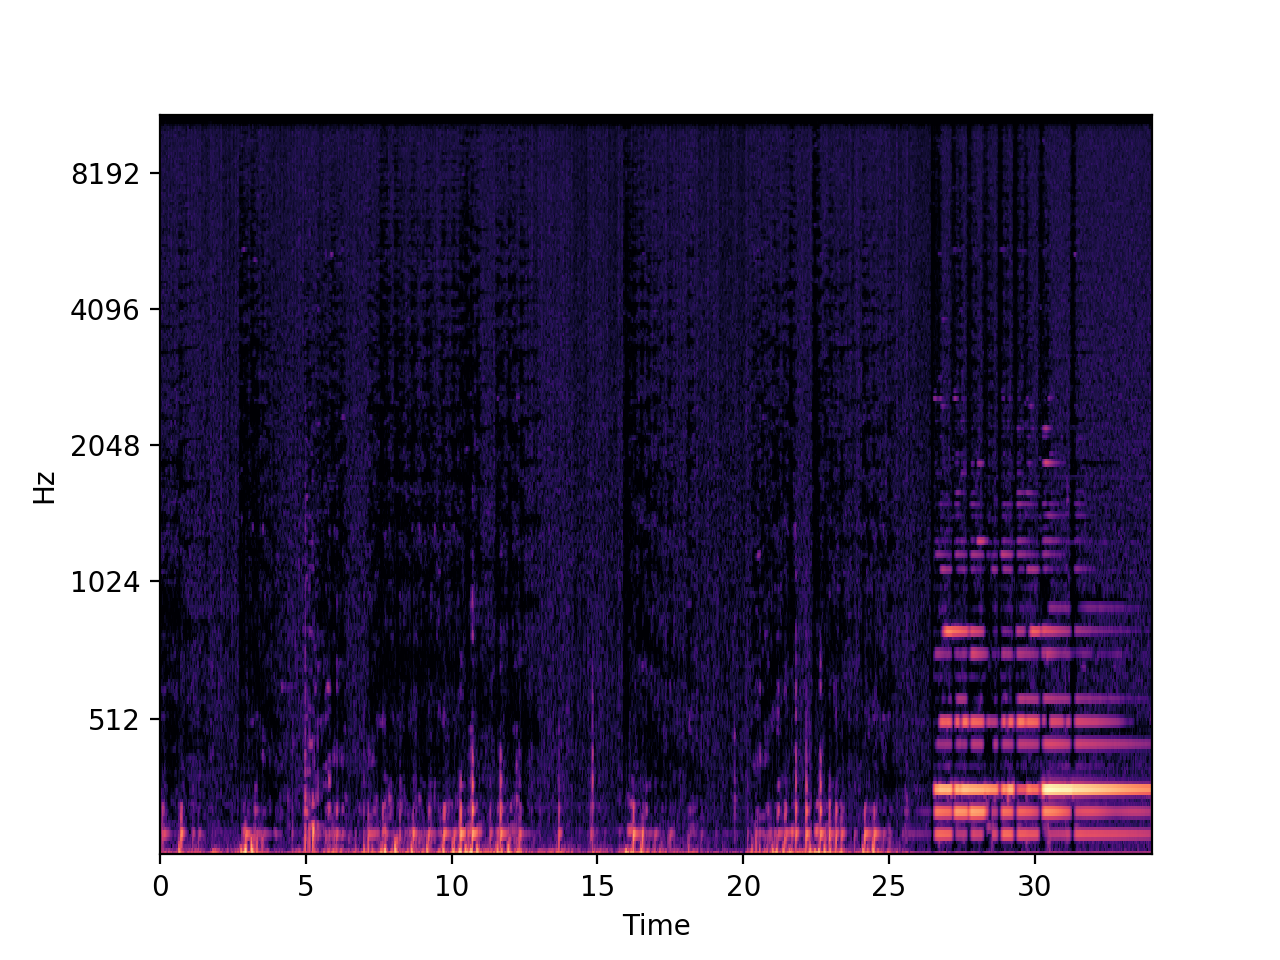

<IPython.core.display.Javascript object>


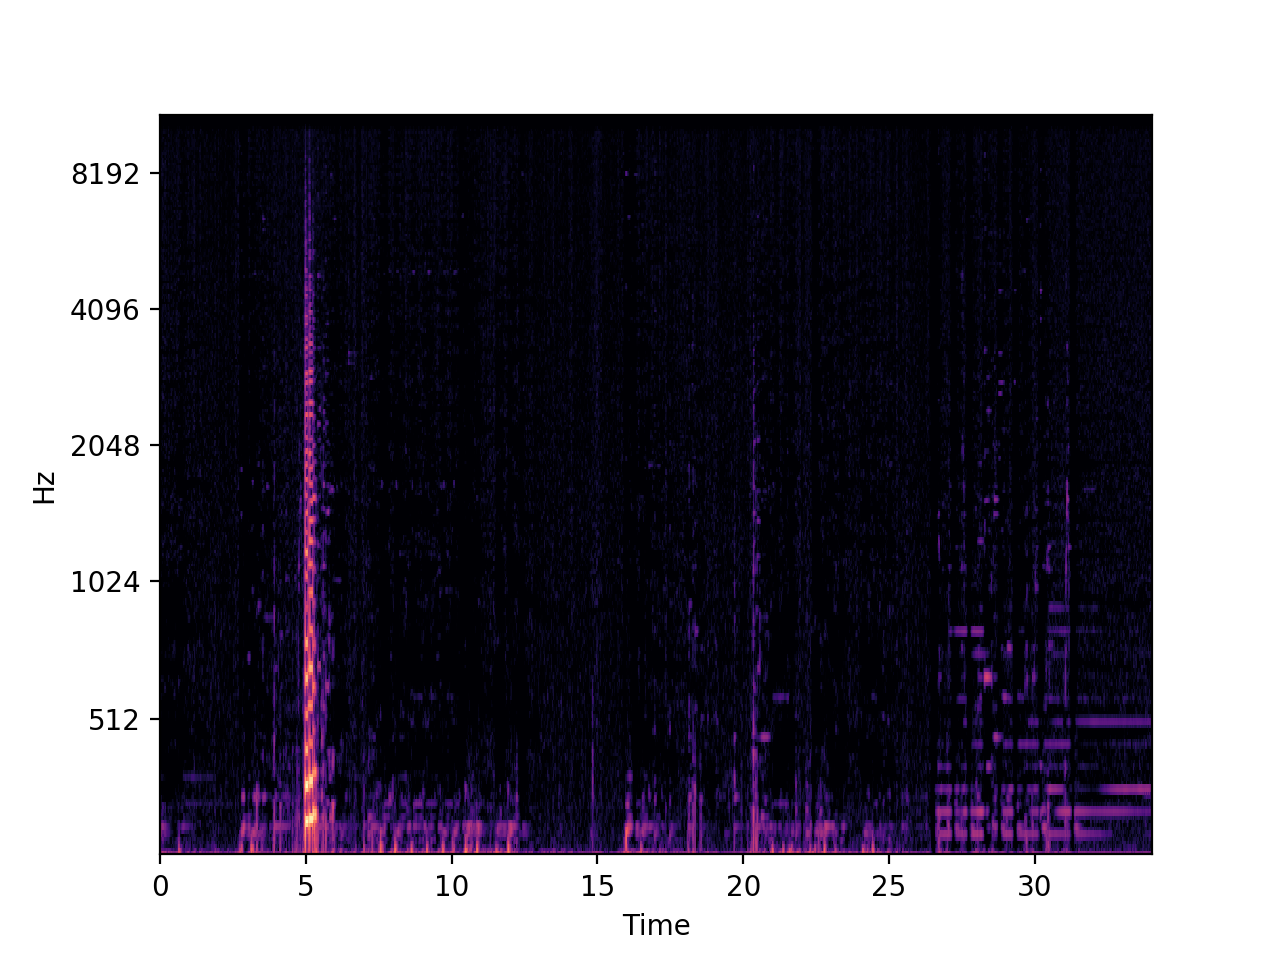

<IPython.core.display.Javascript object>


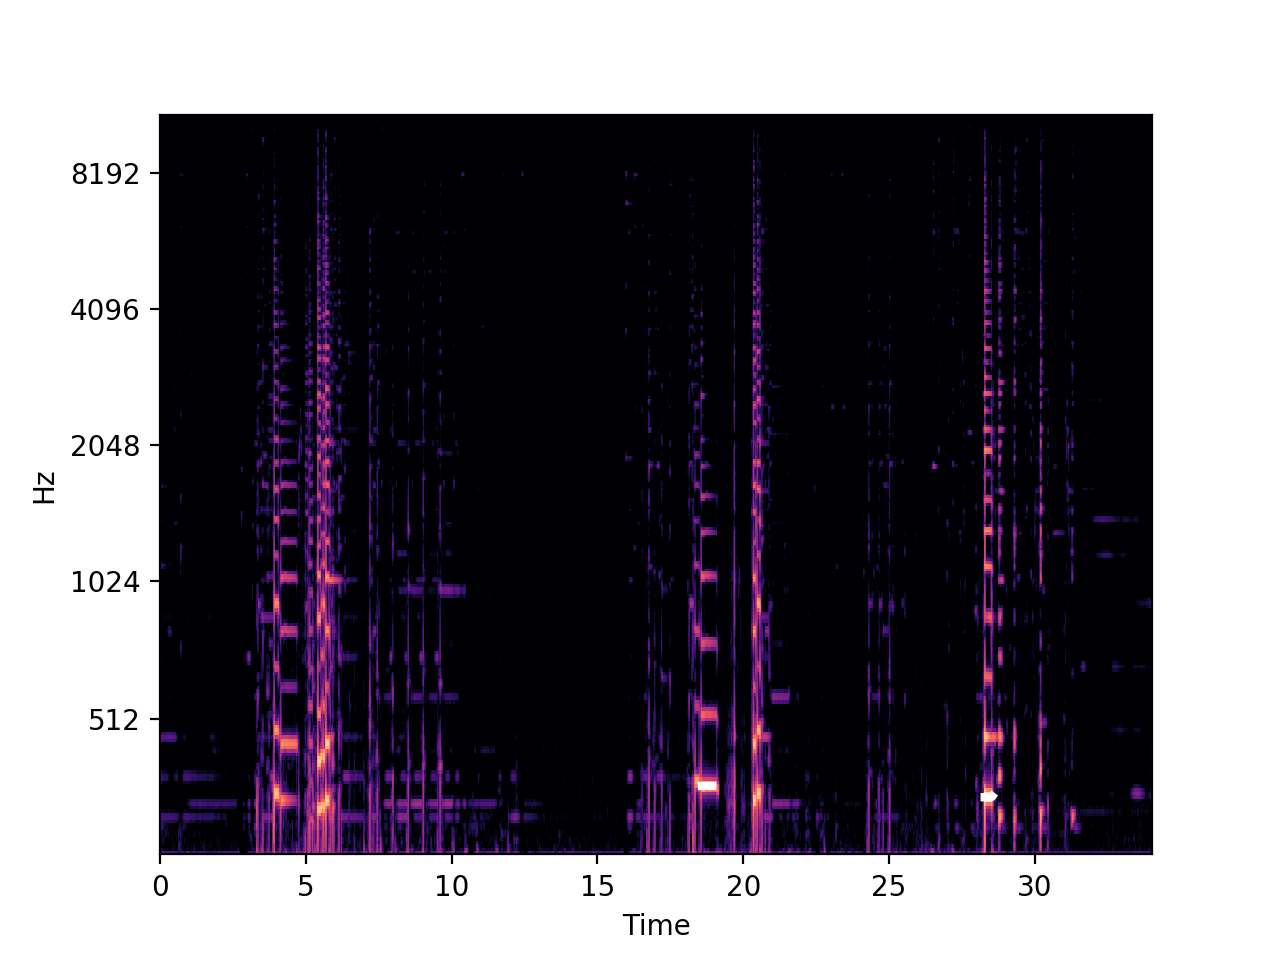

<IPython.core.display.Javascript object>


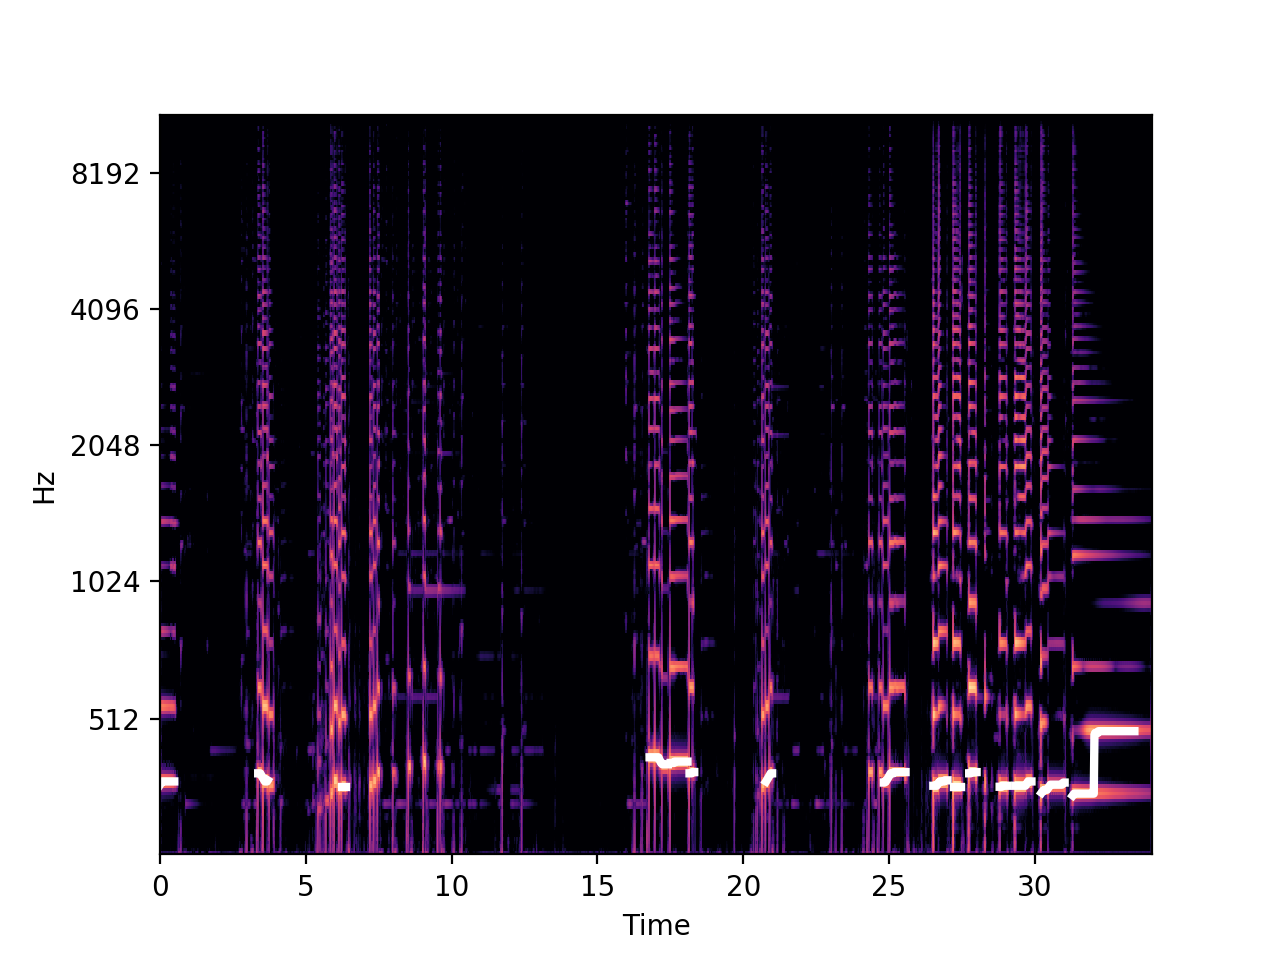

<IPython.core.display.Javascript object>


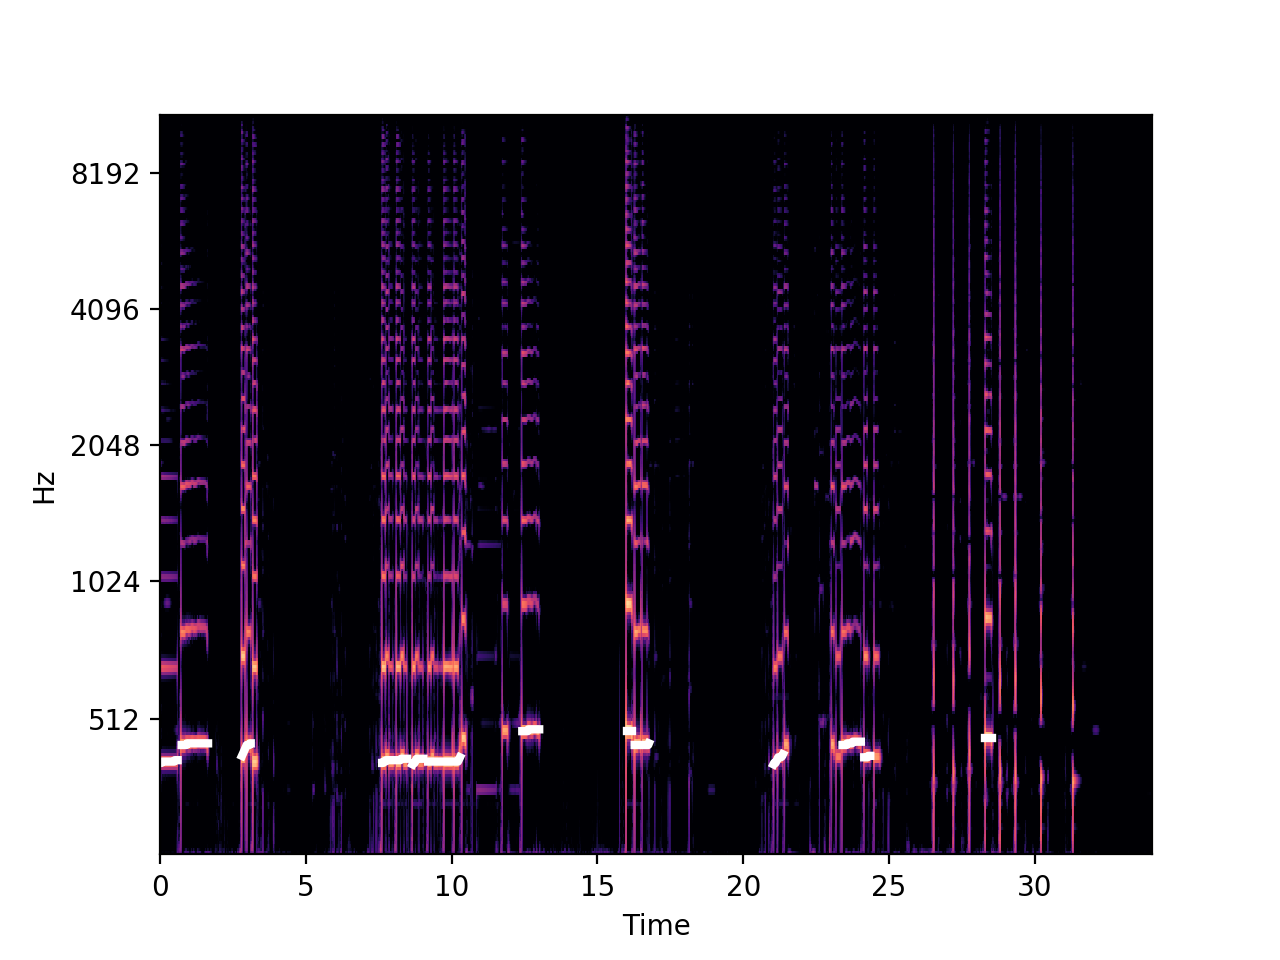

<IPython.core.display.Javascript object>


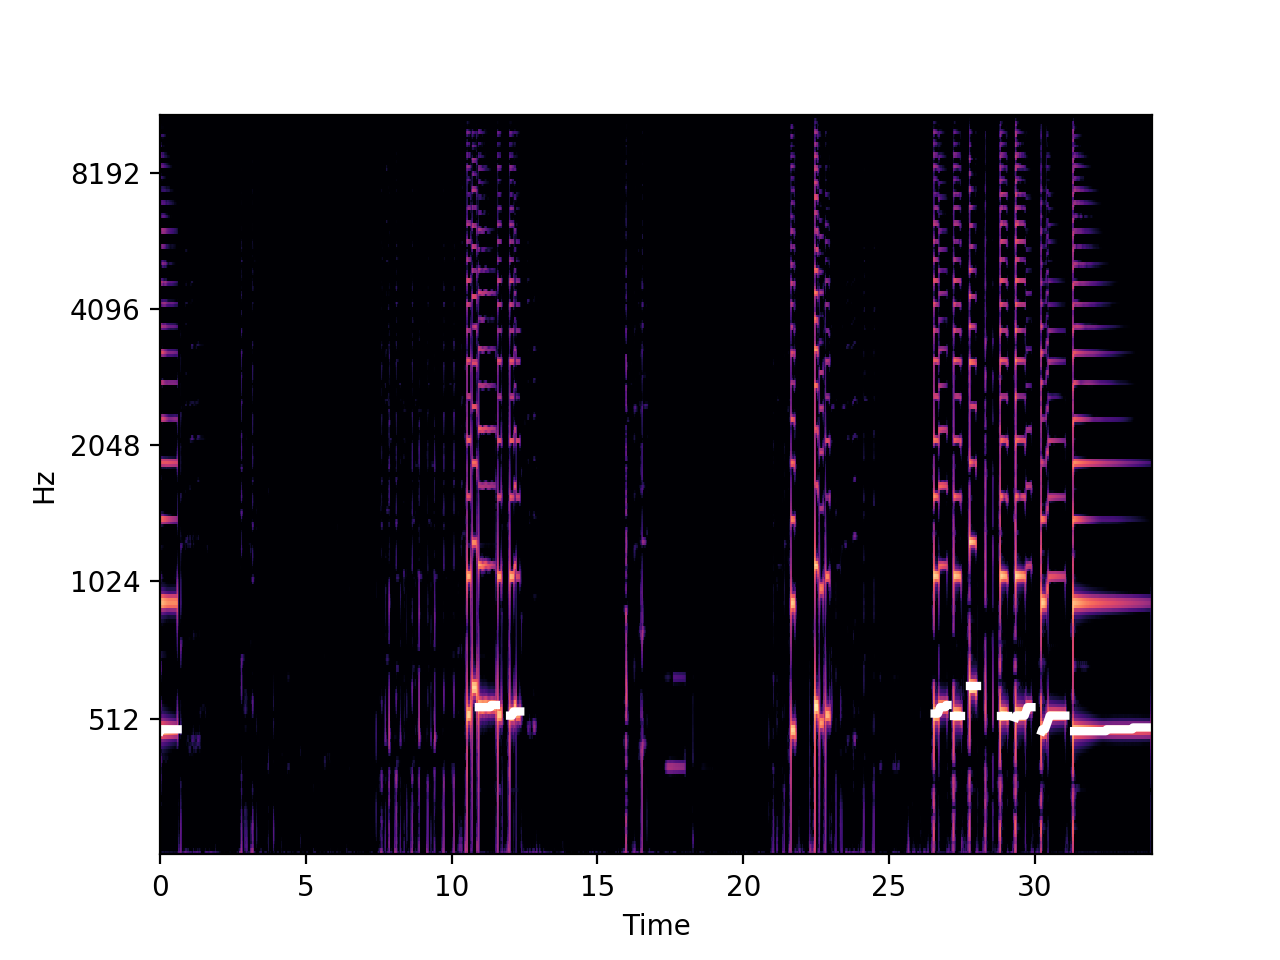

In [28]:
import mir_eval.display
import librosa.display

mono_path = '/Users/tom/Music/DataSet/test-set_processed/vl_Jazz2-110-Bb_s_hex_cln/{}.wav'.format(string_number)

def visualize_joint_states(state_detects, mono_path):
    for string_number in range(6):
    #     mono_path = '/Users/tom/Music/DataSet/test-set_processed/jf_Funk3-112-C#_s_hex_cln/{}.wav'.format(string_number)

        y, sr = librosa.load(mono_path)

        states = state_detects[string_number]
        open_str_midi = str_midi_dict[string_number]
        f_detect = state_to_freq(states, open_str_midi)


        plt.figure()

        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', sr=sr, x_axis='time')

        times = librosa.frames_to_time(np.arange(len(f_detect)))
        mir_eval.display.pitch(times, f_detect, color='w', linewidth=3)
        plt.show()
    #     y_detected = mir_eval.sonify.pitch_contour(times=times, frequencies=f_detect, fs=sr)
    #     Audio(data=y_detected + y[:len(data)], rate=sr)

## Second way of viterbi, across strings

In [13]:
Ps[:,:,0].shape

(6, 105)

<IPython.core.display.Javascript object>


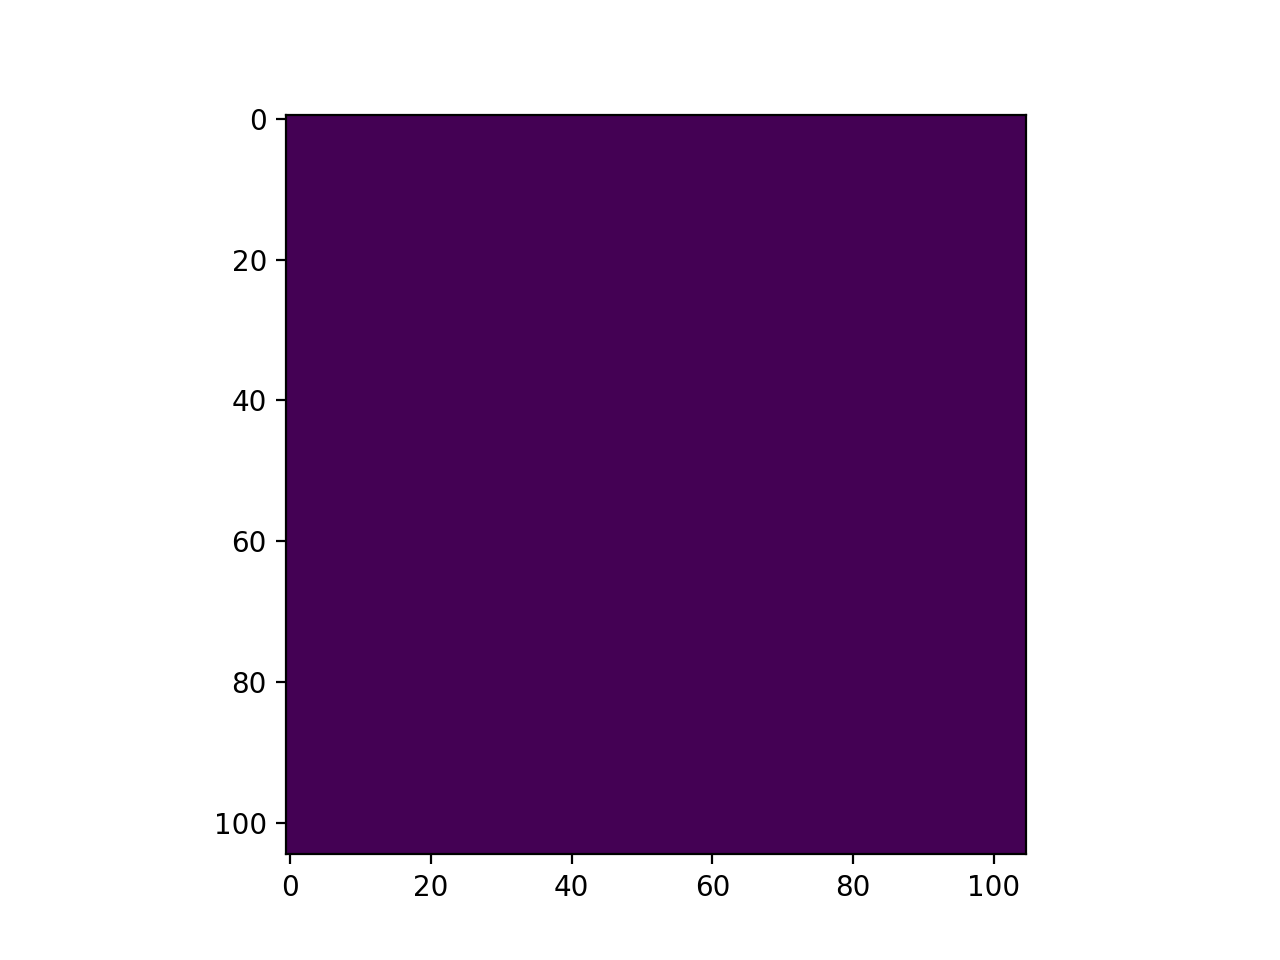

In [21]:
n_pitches = Ps.shape[1]
# T = mod_bump_transition(n_pitches, width=20, alpha=5e-3)
# T = make_bump_transition(n_pitches, width=25, alpha=5e-3)
T = make_uniform_transition(n_pitches)
plt.figure()
plt.imshow(T)

In [22]:
state_detects = []

for frame in range(Ps.shape[2]):
    P = Ps[:,:, frame]
    seq, values, pointers = viterbi(P, T)
    state_detect = seq
    state_detect[seq == n_pitches - 1] *= -1
    state_detects.append(state_detect)
    
state_detects = np.asarray(state_detects).T

<IPython.core.display.Javascript object>


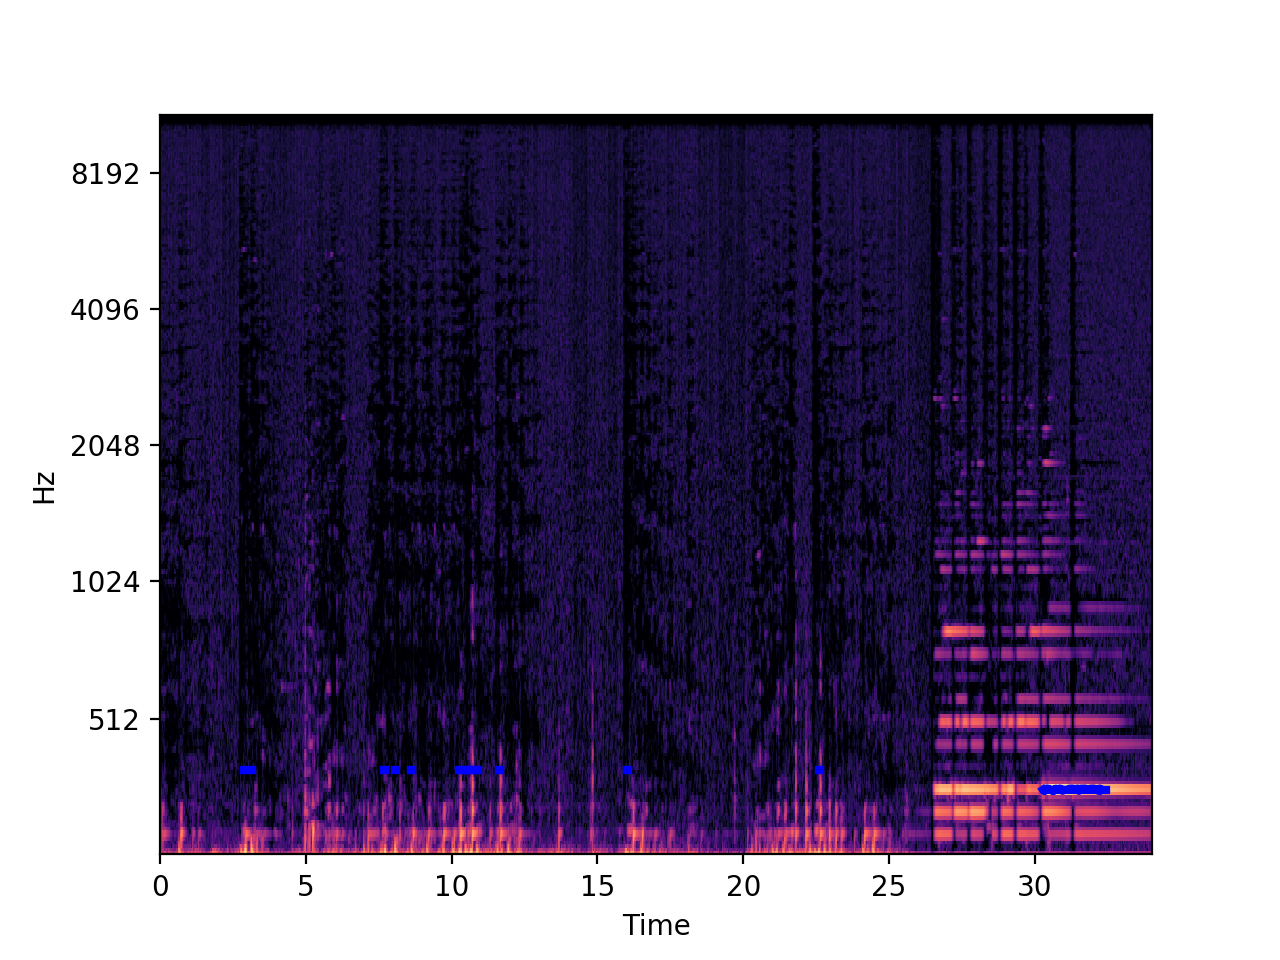

<IPython.core.display.Javascript object>


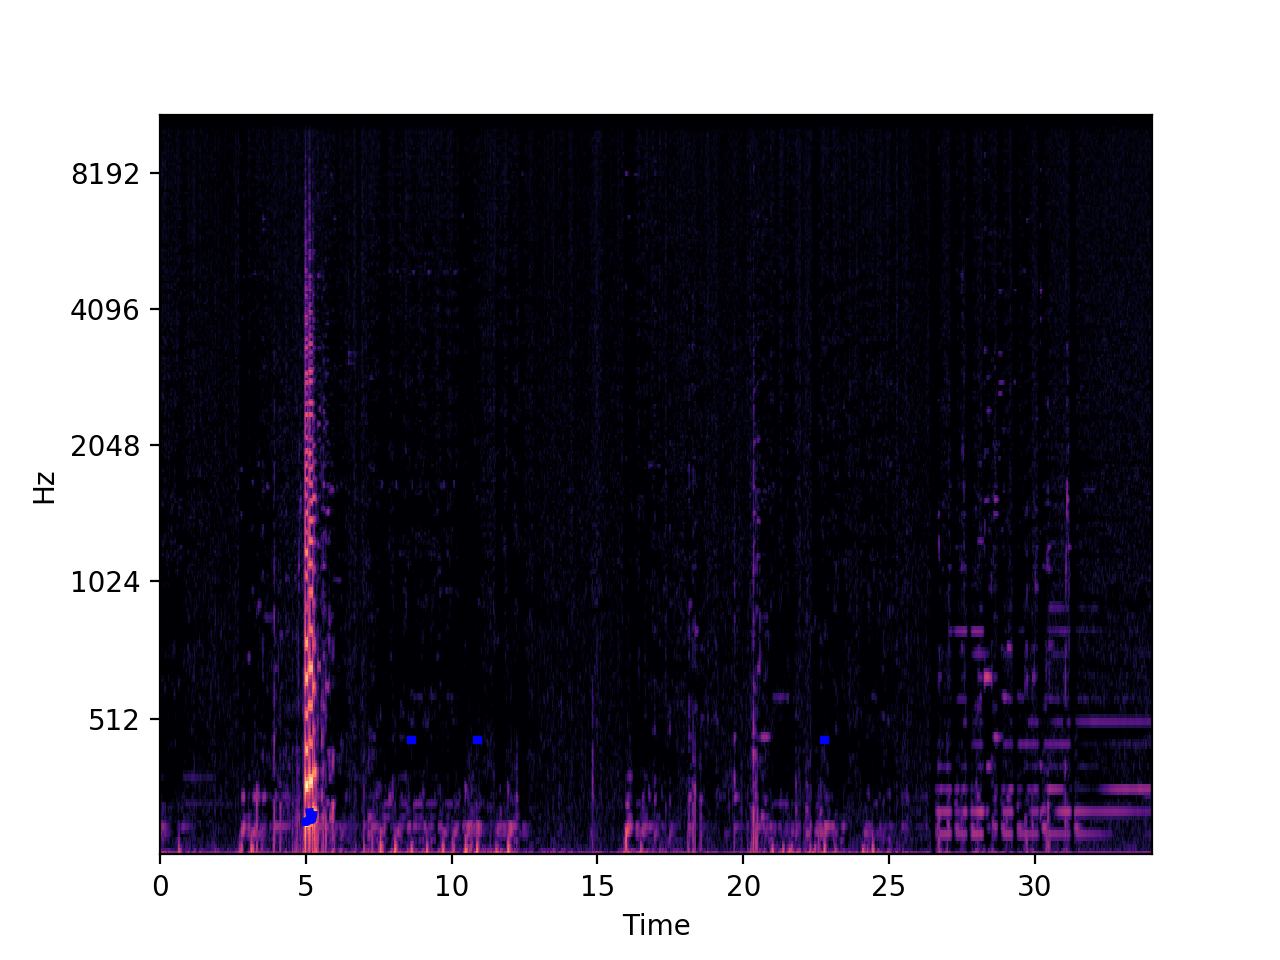

<IPython.core.display.Javascript object>


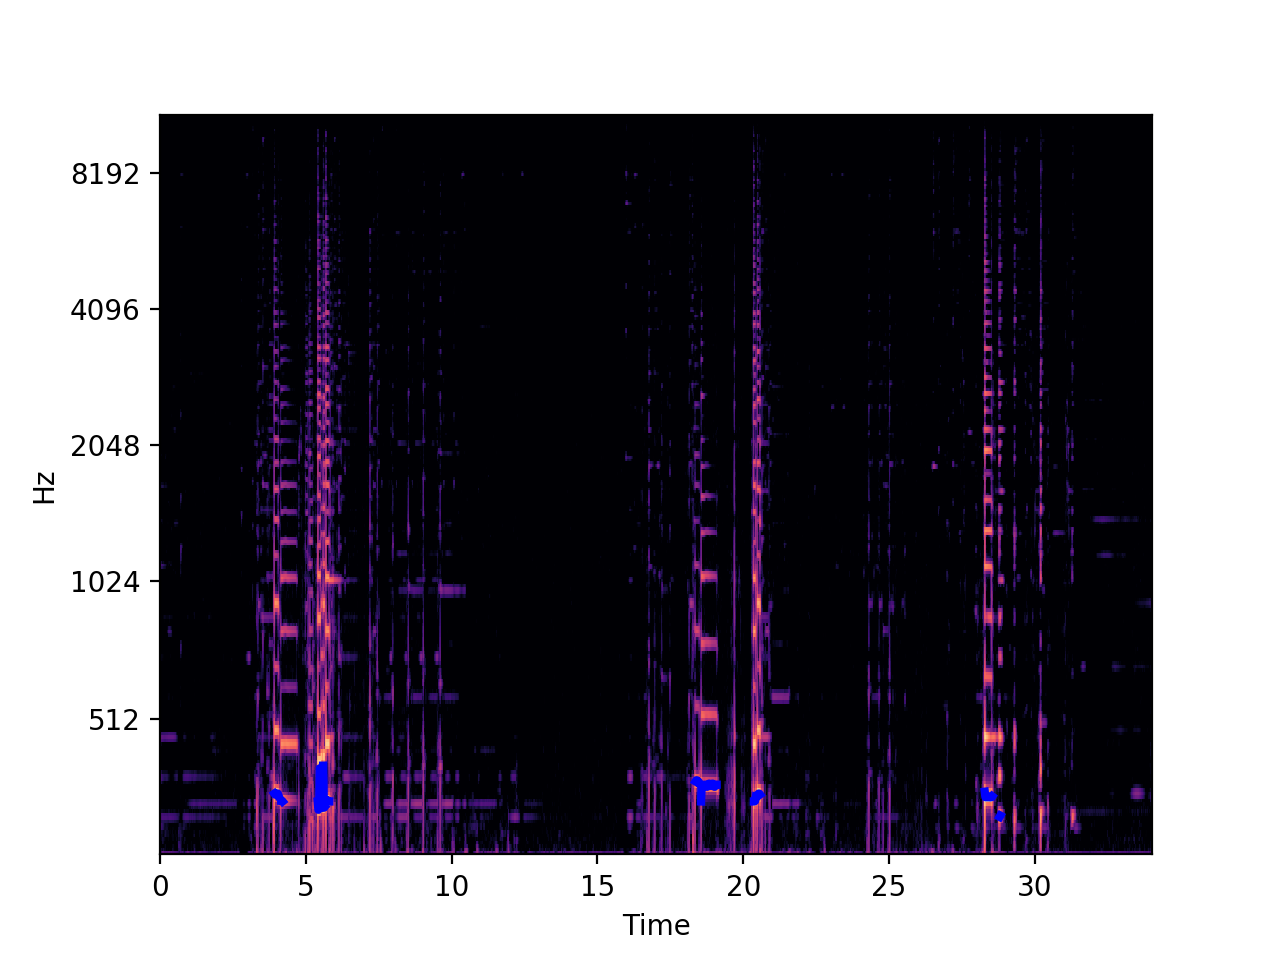

<IPython.core.display.Javascript object>


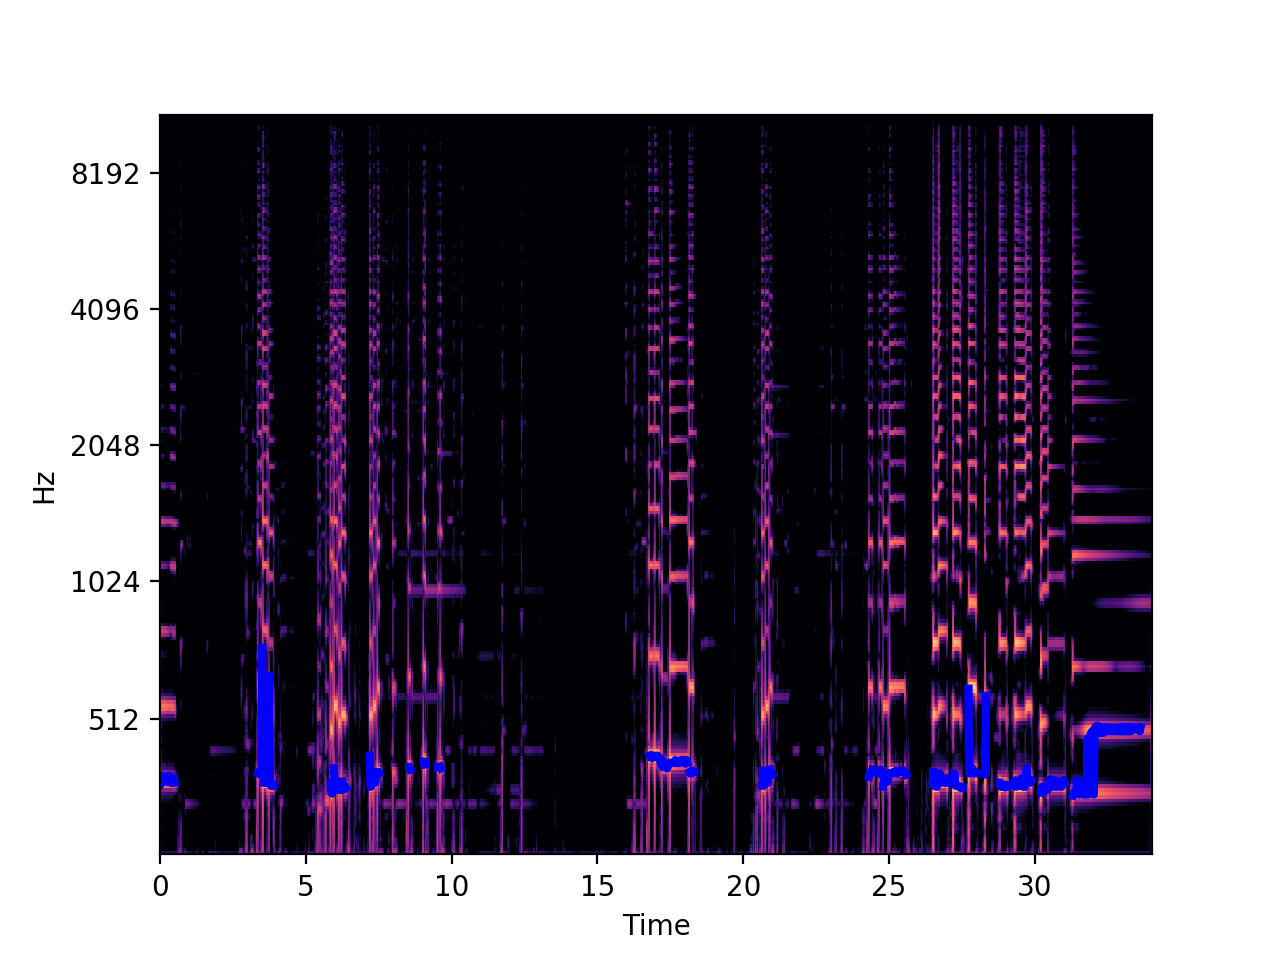

<IPython.core.display.Javascript object>


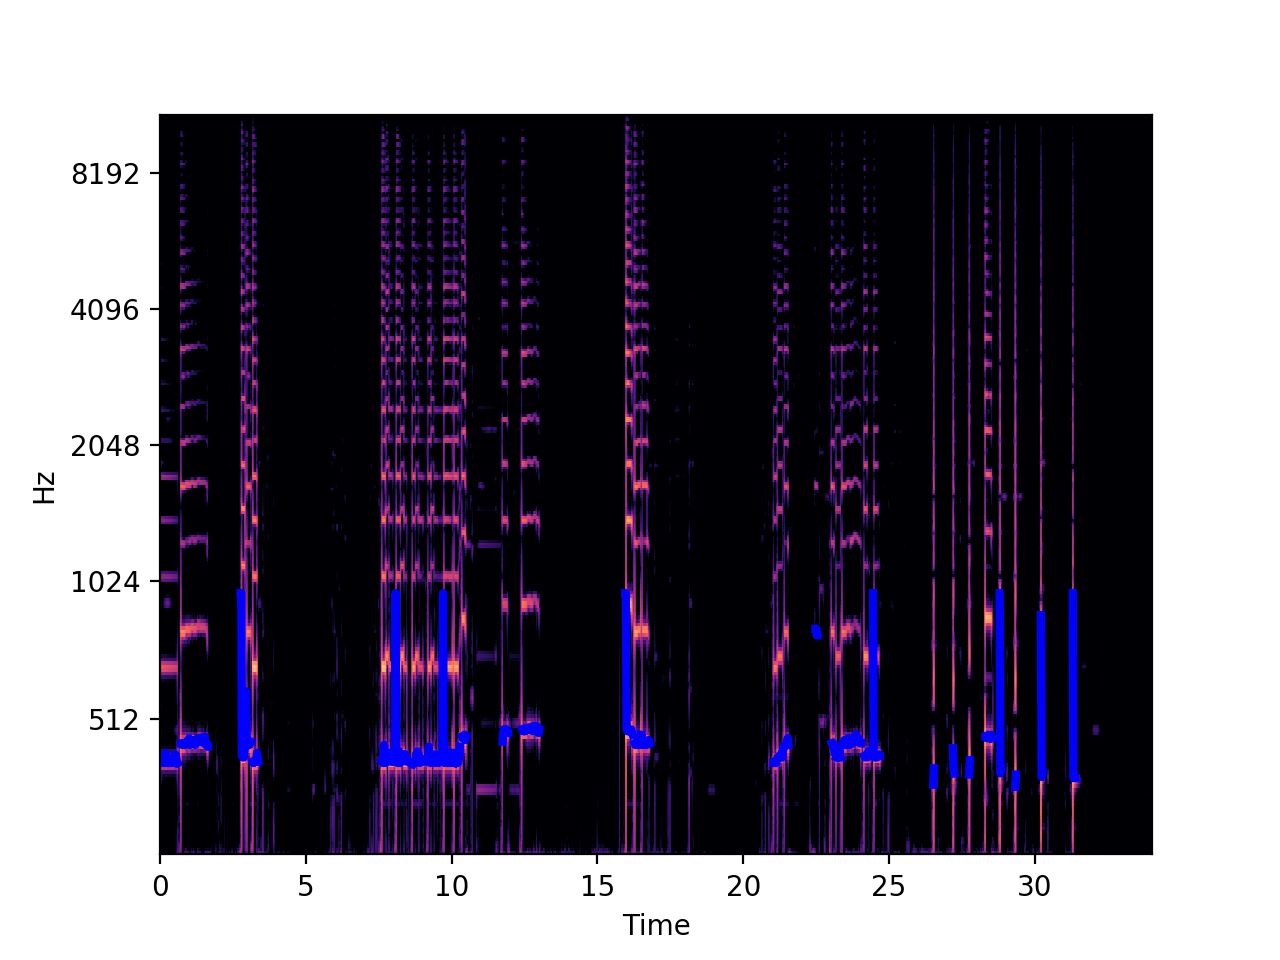

<IPython.core.display.Javascript object>


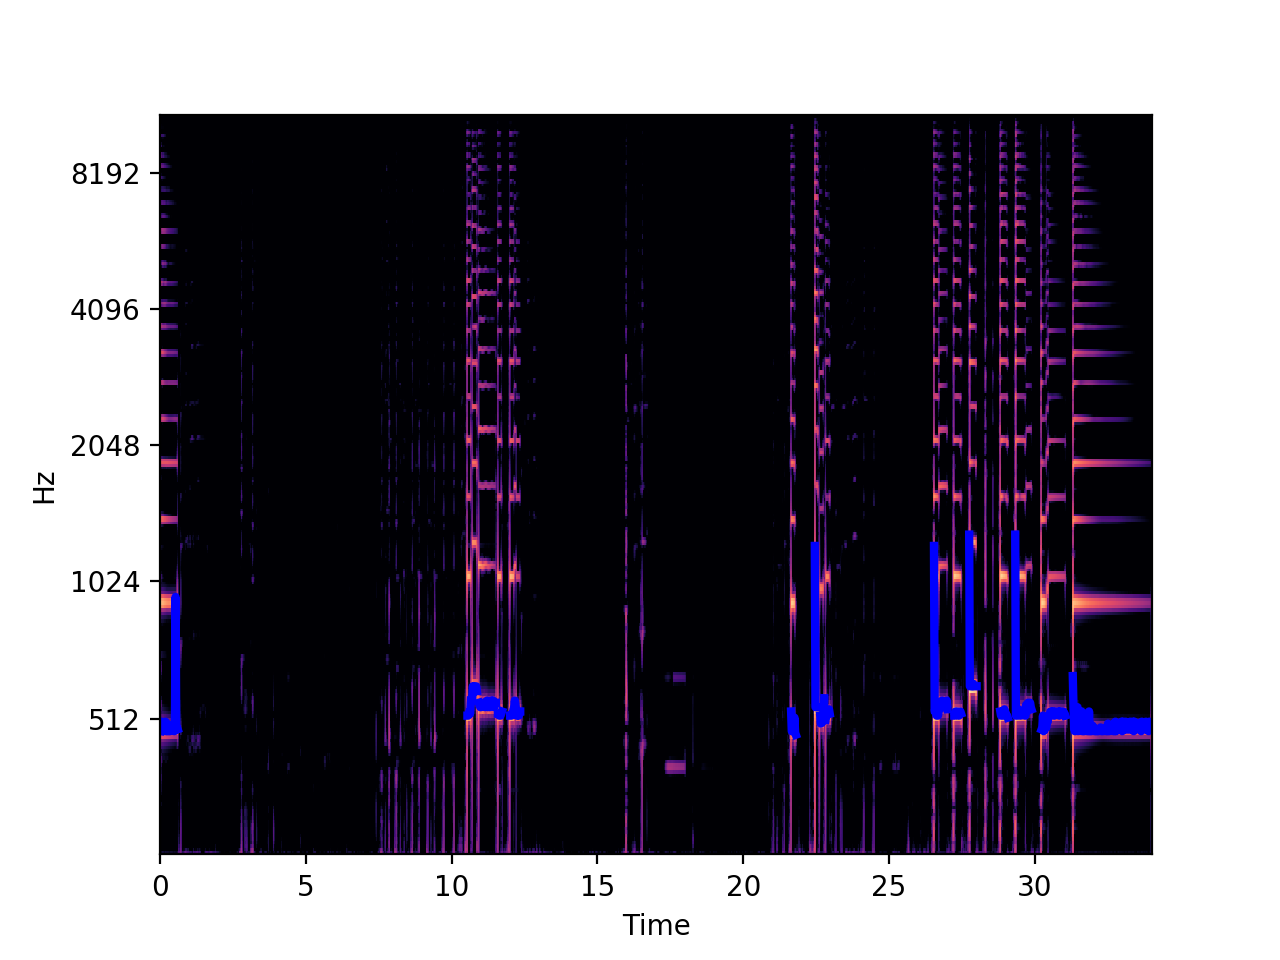

In [23]:
for string_number in range(6):
#     string_number = 1
#     mono_path = '/Users/tom/Music/DataSet/test-set_processed/jf_Funk3-112-C#_s_hex_cln/{}.wav'.format(string_number)
    mono_path = '/Users/tom/Music/DataSet/test-set_processed/vl_Jazz2-110-Bb_s_hex_cln/{}.wav'.format(string_number)
    y, sr = librosa.load(mono_path)

    states = state_detects[string_number]
    open_str_midi = str_midi_dict[string_number]
    f_detect = state_to_freq(states, open_str_midi)


    plt.figure()

    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', sr=sr, x_axis='time')

    times = librosa.frames_to_time(np.arange(len(f_detect)))
    mir_eval.display.pitch(times, f_detect, color='b', linewidth=3)
#     data = mir_eval.sonify.pitch_contour(times=times, frequencies=f_detect, fs=sr)
#     Audio(data=data + y[:len(data)], rate=sr)